In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import expm, logm
from scipy.stats import norm
import statsmodels.api as sm
%matplotlib inline

In [2]:
%%capture
from tqdm.notebook import trange, tqdm
tqdm().pandas()

The computation of the matrix exponential is performed using the Pade approximation:

Reference:

Awad H. Al-Mohy and Nicholas J. Higham (2009) “A New Scaling and Squaring Algorithm for the Matrix Exponential.” SIAM Journal on Matrix Analysis and Applications. 31 (3). pp. 970-989. ISSN 1095-7162

## Loading income data
**Dataset**: rfamxxxx.csv

**Years**: 1998 to 2012 (only even years)

**Variables**:
- *ANNO*: Year
- *NQUEST*: Household ID
- *Y1*: Net disposable income (w/o financial assets)
- *Y2*: Net disposable income

**Note**: data contain a currency shift from thousands of Italian Lire (until 2000) to Euro (from 2002) (1 Euro = 1936.27 Italian Lire).

In [3]:
years = [1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012]
rfam = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/rfam{year}.csv')
    # convert the Italian Lire to Euro for years 1998 and 2000
    if year in [1998, 2000]:
        df['Y2'] = df['Y2']*1000/1936.27
        df['Y1'] = df['Y1']*1000/1936.27
    # rename income to Y_xxxx
    #df.rename(columns={'Y2':f'Y'}, inplace=True)
    # fix the lower-case header for 2008 and 2012
    if year in [2008, 2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # filter only columns of interest
    df = df[['ANNO','NQUEST','Y1','Y2']]
    rfam.append(df)
rfam = pd.concat(rfam)

1998 2000 2002 2004 2006 2008 2010 2012 

In [4]:
rfam

,ANNO,NQUEST,Y1,Y2
0,1998,34,80050.819359,79761.603495
1,1998,123,6197.482789,1323.722054
2,1998,173,20761.567343,21034.256586
3,1998,304,12911.422477,13820.386620
4,1998,325,15803.581112,16236.758806
...,...,...,...,...
8146,2012,889749,21778.000000,21956.020998
8147,2012,889750,14800.000000,14925.801505
8148,2012,889751,26000.000000,26178.020998
8149,2012,889752,23100.000000,23131.980055


In [5]:
# descriptive stats for the original dataset
rfam[['Y1','Y2']].describe()

,Y1,Y2
count,6.301800e+04,6.301800e+04
mean,2.974698e+04,3.018494e+04
std,2.340649e+04,2.426811e+04
min,-4.338238e+04,-4.157511e+04
25%,1.598792e+04,1.601016e+04
50%,2.460000e+04,2.482162e+04
75%,3.760000e+04,3.801351e+04
max,1.024568e+06,1.022617e+06


In [6]:
rfam[(rfam['Y1']<0)|(rfam['Y2']<0)]

,ANNO,NQUEST,Y1,Y2
50,1998,4370,-43382.379524,-39084.425209
513,1998,29421,-13796.115387,-13796.115387
1007,1998,34224,-68.370257,352.868994
4099,1998,505327,-39297.205452,-39669.054419
4279,1998,505782,-8890.723463,-6432.737098
4657,1998,506714,-19701.663105,-18672.880962
700,2000,33781,1394.433628,-201.521482
4002,2000,611518,1859.244837,-693.085159
897,2004,91043,-5705.949686,-5693.503837
1313,2004,506132,-6400.000000,-6214.114000


In [9]:
# remove households with negative Y2
neg_nquest = rfam[(rfam['Y2']<0)]['NQUEST']
rfam = rfam[~rfam['NQUEST'].isin(neg_nquest)]
rfam

,ANNO,NQUEST,Y1,Y2
0,1998,34,80050.819359,79761.603495
1,1998,123,6197.482789,1323.722054
2,1998,173,20761.567343,21034.256586
3,1998,304,12911.422477,13820.386620
4,1998,325,15803.581112,16236.758806
...,...,...,...,...
8146,2012,889749,21778.000000,21956.020998
8147,2012,889750,14800.000000,14925.801505
8148,2012,889751,26000.000000,26178.020998
8149,2012,889752,23100.000000,23131.980055


## Load info dataset

**Dataset**: compxxxx.csv

**Variables**:
- *ANNO*: year
- *NQUEST*: Household ID
- *NCOMP*: Number of household members
- *AREA3*: 1=North, 2=Centre, 3=South and Islands
- *SESSO*: Sex
- *ETA*: Age(years)
- *ETA5*: Age groups:
    - 1 = up to 30 years
    - 2 = from 31 to 40 years
    - 3 = from 41 to 50 years
    - 4 = from 51 to 65 years
    - 5 = more than 65 years
- *STUDIO*: Educational qualification: 
    - 1 = none
    - 2 = elementary school
    - 3 = middle school
    - 4 = high school
    - 5 = bachelor’s degree
    - 6 = post-graduate qualification.

In [10]:
cols = ['ANNO','NQUEST','NCOMP','AREA3']
comp = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/comp{year}.csv')
    # fix the lower-case header for 2012
    if year in [2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # create the dataset with the value counts of the Age group
    A5 = df.groupby('NQUEST')['ETA5'].value_counts().to_frame().rename(columns={'ETA5':'COUNT'}).reset_index()
    A5 = pd.pivot_table(A5, values='COUNT', index='NQUEST', columns='ETA5')
    A5.columns = ['A'+str(x+1) for x in range(5)]
    A5.reset_index(inplace=True)
    A5 = A5.fillna(0).astype(dtype='int')
    # filter only columns of interest and drop duplicates
    df = df[cols].drop_duplicates()
    if len(df)-len(A5):
        print('ERROR while merging A5 with df')
    # join df with A5
    df = pd.merge(df, A5, how='left', on='NQUEST')
    # join datasets
    comp.append(df)
comp = pd.concat(comp)

1998 2000 2002 2004 2006 2008 2010 2012 

In [11]:
comp

,ANNO,NQUEST,NCOMP,AREA3,A1,A2,A3,A4,A5
0,1998,34,4,1,2,0,0,2,0
1,1998,123,4,3,2,0,0,2,0
2,1998,173,4,3,2,0,2,0,0
3,1998,304,3,3,1,2,0,0,0
4,1998,325,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
8146,2012,889749,3,3,1,0,0,0,2
8147,2012,889750,1,1,1,0,0,0,0
8148,2012,889751,2,1,2,0,0,0,0
8149,2012,889752,4,3,2,0,0,2,0


## Load poverty lines

In [13]:
pov = pd.read_csv('data.nosync/poverty lines.csv')
# convert the Italian Lire to Euro for years before 2000
pov.loc[:,'1997':'2000'] = pov.loc[:,'1997':'2000']/1936.27
pov = pov.set_index('NCOMP').unstack().to_frame().reset_index()
pov.columns = ['ANNO','COMP','Yp']
pov['Yp'] = pov['Yp']*12
pov['ANNO'] = pov['ANNO'].astype(dtype='int')
# drop 1997 observations
pov = pov[pov['ANNO']>1997].reset_index(drop=True)
# compute scale factor for income across number of components
pov['Yscale'] = (pov.set_index('ANNO')['Yp']/pov.groupby('ANNO')['Yp'].first()).reset_index(drop=True)
# compute scale factor for income over time
time_scale = (pov.groupby('ANNO')['Yp'].first()/pov.groupby('ANNO')['Yp'].first().loc[1998]).to_frame()
time_scale.columns = ['Tscale']
pov = pov.merge(time_scale, how='left', left_on=['ANNO'], right_index=True)
pov

,ANNO,COMP,Yp,Yscale,Tscale
0,1998,1,5479.498210,1.000000,1.000000
1,1998,2,9147.744891,1.669449,1.000000
2,1998,3,12212.238996,2.228715,1.000000
3,1998,4,14929.122488,2.724542,1.000000
4,1998,5,17426.453955,3.180301,1.000000
...,...,...,...,...,...
107,2013,3,15521.400000,2.216672,1.277876
108,2013,4,19022.520000,2.716680,1.277876
109,2013,5,22173.480000,3.166681,1.277876
110,2013,6,25207.680000,3.600007,1.277876


### Evolution of poverty thresholds 

In [15]:
pov.pivot_table(values='Yp', index=['ANNO'], columns=['COMP'])

COMP,1,2,3,4,5,6,7
ANNO,,,,,,,
1998,5479.498210,9147.744891,12212.238996,14929.122488,17426.453955,19667.649656,21963.736462
1999,5549.157917,9248.596528,12300.633693,15075.209552,17572.336503,19884.480987,22196.631668
2000,5833.535612,9722.555222,12930.998260,15847.762967,18472.855542,21000.722007,23334.130054
2001,5864.760000,9774.600000,13000.320000,15932.640000,18571.800000,21113.160000,23459.160000
2002,5919.600000,9866.040000,13121.880000,16081.680000,18745.440000,21310.680000,23678.520000
2003,6298.080000,10496.880000,13960.800000,17109.960000,19944.120000,22673.280000,25192.560000
2004,6623.880000,11039.760000,14682.840000,17994.840000,20975.520000,23845.920000,26495.400000
2005,6743.400000,11238.960000,14947.800000,18319.560000,21354.000000,24276.120000,26973.480000
2006,6986.400000,11644.080000,15486.600000,18979.800000,22123.800000,25151.160000,27945.840000


## Combine the datasets and compute poverty classes

In [16]:
df = pd.merge(rfam, comp, how='left', on=['ANNO','NQUEST'])
# adjust NCOMP to have max 7 categories by components to merge with poverty thresholds
df['COMP'] = df['NCOMP'].mask(df['NCOMP']>7,7)
# combine df with poverty thersholds
df = pd.merge(df, pov, how='left', on=['ANNO','COMP'])
# compute exterme poverty thershold as % of Yp
Yp_perc = .5
df['Yep'] = Yp_perc*df['Yp']
# compute the poverty classes
df['C'] = 2
df['C'] = df['C'].mask(df['Y2']<=df['Yp'], 1)
df['C'] = df['C'].mask(df['Y2']<=df['Yep'], 0)
# compute equivalent incomes and classes
df['Ye'] = df['Y2']/df['Yscale']/df['Tscale']
df['Ce'] = 2
df['Ce'] = df['Ce'].mask(df['Y2']<=df['Yp']/df['Yscale'], 1)
df['Ce'] = df['Ce'].mask(df['Y2']<=df['Yep']/df['Yscale'], 0)
df

,ANNO,NQUEST,Y1,Y2,NCOMP,AREA3,A1,A2,A3,A4,A5,COMP,Yp,Yscale,Tscale,Yep,C,Ye,Ce
0,1998,34,80050.819359,79761.603495,4,1,2,0,0,2,0,4,14929.122488,2.724542,1.00000,7464.561244,2,29275.234627,2
1,1998,123,6197.482789,1323.722054,4,3,2,0,0,2,0,4,14929.122488,2.724542,1.00000,7464.561244,0,485.851237,0
2,1998,173,20761.567343,21034.256586,4,3,2,0,2,0,0,4,14929.122488,2.724542,1.00000,7464.561244,2,7720.291090,2
3,1998,304,12911.422477,13820.386620,3,3,1,2,0,0,0,3,12212.238996,2.228715,1.00000,6106.119498,2,6201.056479,2
4,1998,325,15803.581112,16236.758806,2,1,0,1,0,1,0,2,9147.744891,1.669449,1.00000,4573.872445,2,9725.816787,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62965,2012,889749,21778.000000,21956.020998,3,3,1,0,0,0,2,3,15814.440000,2.216659,1.30201,7907.220000,2,7607.476317,2
62966,2012,889750,14800.000000,14925.801505,1,1,1,0,0,0,0,1,7134.360000,1.000000,1.30201,3567.180000,2,11463.663543,2
62967,2012,889751,26000.000000,26178.020998,2,1,2,0,0,0,0,2,11890.560000,1.666661,1.30201,5945.280000,2,12063.554552,2
62968,2012,889752,23100.000000,23131.980055,4,3,2,0,0,2,0,4,19381.560000,2.716650,1.30201,9690.780000,2,6539.806048,2


## Analysis of trajectories
### Filter the dataset to exclude single year income and gaps between years

In [17]:
# Create a table with all sequence (for filtering df)
Y = df.pivot_table(values='Ye', columns=['ANNO'], index=['NQUEST'])
Y

ANNO,1998,2000,2002,2004,2006,2008,2010,2012
NQUEST,,,,,,,,
34,29275.234627,27435.215612,35283.873183,45105.134705,NaN,NaN,NaN,NaN
123,485.851237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,7720.291090,8341.399201,10083.540404,8069.352246,10654.437571,15624.923005,15306.150503,38200.452796
304,6201.056479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,9725.816787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
889749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7607.476317
889750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11463.663543
889751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12063.554552


In [23]:
# get the households index with complete trajectories from 1998 to 2012
nquest_index_full_traj = Y.dropna().index
# filter the dataframe
df = df[df['NQUEST'].isin(nquest_index_full_traj)]
print('Number of housholds with complete trajectories from 1998 to 2012:', len(df['NQUEST'].unique()))

Number of housholds with complete trajectories from 1998 to 2012: 914


## Descriptive statistics

### Income stats by components

In [24]:
df.groupby(['COMP'])['Ye'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
COMP,,,,,,,,
1,1101.0,15358.05,10539.19,0.00,9164.47,13183.66,18895.25,200125.84
2,2258.0,14995.72,9448.49,784.61,9153.48,13088.55,18421.79,222822.47
3,1702.0,14532.65,9592.02,0.00,8918.06,13012.51,17754.19,112369.43
4,1627.0,12106.83,7529.16,0.00,7306.33,10837.33,14957.06,101693.05
5,490.0,10114.09,5774.25,0.00,5556.53,9615.55,13399.05,35573.93
6,109.0,10323.97,5783.92,0.00,6426.38,9770.16,12791.52,37650.18
7,25.0,14407.41,10798.38,3033.78,8771.85,11224.28,16944.50,56228.42


### Income stats by components and year

In [25]:
df.groupby(['COMP','ANNO'])['Ye'].describe().round(2)

count      mean       std       min       25%       50%       75%  \
COMP ANNO                                                                      
1    1998   90.0  14138.35   8816.95    449.02   8747.49  11487.78  18340.42   
     2000  101.0  15142.21   7878.46   1649.38   9314.17  13874.24  19416.73   
     2002  111.0  16404.43  10342.82      0.00   9325.63  13273.21  20678.95   
     2004  128.0  14711.59   8076.07   3143.49   8987.90  13105.41  18781.96   
     2006  136.0  15107.63   9579.92   4078.41   8509.71  12776.31  19114.54   
     2008  160.0  14865.08   9506.58      0.00   9157.24  13177.03  18024.05   
     2010  179.0  16509.03  16377.07    920.18   9711.45  13717.99  19083.78   
     2012  196.0  15383.99   8445.01   3463.88   9268.08  13153.48  18902.16   
2    1998  203.0  14637.67   9791.52    784.61   8591.43  11974.62  17315.65   
     2000  228.0  14143.71   8656.91   1726.03   8784.43  12454.80  17304.57   
     2002  242.0  14963.10   9023.53   3110.18   9288.89  12798.65  18811.83   
     2004  270.0  14350.52   8069.99   2919.97   8862.22  12592.89  17612.68   
     2006  307.0  15382.19  14071.30   1844.68   9369.78  13167.37  18180.25   
     2008  320.0  14965.72   7626.96   3197.43   9452.97  13445.55  18588.27   
     2010  337.0  15593.04   8652.50   1012.21   9326.07  13977.65  19313.46   
     2012  351.0  15390.88   8132.11   1917.04   9698.22  13692.05  18814.54   
3    1998  244.0  13317.51   9565.42      0.00   8289.13  11795.54  15982.35   
     2000  229.0  13850.06   7531.43   1832.85   8241.16  13335.95  17702.62   
     2002  231.0  15012.10  10551.42   1818.58   9700.39  12762.60  18159.85   
     2004  219.0  14034.27   9215.03   2239.14   8625.62  12348.76  17176.85   
     2006  210.0  14193.89   8551.54   2122.93   8982.62  12605.47  17362.45   
     2008  196.0  14761.12   8379.55   1442.45   9580.78  13782.21  17821.97   
     2010  192.0  15191.34   8525.47   2263.94   9502.74  14134.64  18221.23   
     2012  181.0  16472.31  13537.39   1713.12   9762.97  14225.45  18880.40   
4    1998  268.0  11783.78   7808.87      0.00   6974.78  10448.90  14734.23   
     2000  255.0  11604.47   6680.43   1071.42   7255.90  10469.63  14393.76   
     2002  238.0  12299.93   6781.05      0.00   7563.42  11283.56  15422.31   
     2004  214.0  11930.71   7317.48    411.08   7322.75  11021.23  14877.59   
     2006  182.0  12012.99   9051.15   1732.21   7229.61  10460.77  14383.49   
     2008  174.0  12192.64   7546.40   1457.20   7296.52  11020.90  14918.28   
     2010  154.0  13168.36   7794.74   1504.48   7973.34  11603.13  15665.43   
     2012  142.0  12424.31   7523.27      0.00   7288.53  11175.16  15475.81   
5    1998   90.0   8676.17   5185.59      0.00   4214.46   8695.15  11656.04   
     2000   81.0   9880.23   5625.49    796.61   5443.55   9373.92  12591.47   
     2002   74.0  10739.47   6176.65    175.39   5813.81  10540.16  13922.63   
     2004   66.0  11121.93   5984.75    835.95   5813.90  10885.44  15938.22   
     2006   63.0  10182.98   5567.99   1040.23   5144.20   9357.76  14616.70   
     2008   47.0  10600.05   6841.44      0.00   5729.15  11083.90  13589.49   
     2010   37.0  10037.52   5444.55      0.00   6040.38  10851.78  13457.93   
     2012   32.0  10464.47   5148.57   1350.95   7255.34   9153.87  12837.27   
6    1998   16.0   8002.68   5055.31   1762.33   5916.86   6480.34  10686.53   
     2000   18.0  10295.98   8565.44      0.00   4998.42   8776.88  11264.25   
     2002   15.0  10419.76   4970.21   3419.76   7702.13   9770.16  12731.20   
     2004   14.0   8896.92   3621.40   3456.35   5915.19   9125.82  11047.53   
     2006   12.0  12591.90   5653.76   6537.13   9291.53  10985.27  13890.55   
     2008   14.0  10948.79   6743.36   3335.14   5914.77   9763.30  13599.92   
     2010   11.0  11413.25   4253.03   4431.89   8551.31  12387.30  14049.64   
     2012    9.0  11239.69   4179.98   4568.12   7428.00  12973.49  14114.71   
7    1998  

### Income stats by poverty class

In [26]:
df.groupby(['C'])['Ye'].describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0,119.0,1642.529233,861.559551,0.000000,1049.048459,1832.853002,2349.971977,2737.982119
1,479.0,4301.892236,748.278755,2742.807734,3699.023863,4387.651247,4945.987487,5467.459496
2,6714.0,14802.988481,9023.689975,5480.918194,9360.715950,12870.518301,17698.428174,222822.468181


### Income stats by poverty class and year

In [27]:
df.groupby(['C','ANNO'])['Ye'].describe()

count          mean           std          min          25%  \
C ANNO                                                                
0 1998   32.0   1390.502020    909.872464     0.000000   702.184782   
  2000   19.0   1948.488429    701.538411     0.000000  1779.443106   
  2002   15.0   1261.422628    936.890028     0.000000   416.690072   
  2004    9.0   1717.321794    817.107627   411.080209   901.497213   
  2006   11.0   2130.894554    579.480245  1040.232351  1788.446086   
  2008   10.0   1595.918426    996.250321     0.000000  1144.945607   
  2010   14.0   1740.082671    853.685723     0.000000  1104.223184   
  2012    9.0   1756.246289    769.509164     0.000000  1713.124150   
1 1998   76.0   4197.647972    762.442557  2786.464391  3565.833297   
  2000   75.0   4217.301902    727.289823  2870.841504  3672.037631   
  2002   63.0   4265.824061    747.911333  2743.532424  3672.788430   
  2004   72.0   4319.190394    788.291461  2910.886861  3701.203520   
  2006   57.0   4444.678761    714.778368  2742.807734  4020.896933   
  2008   55.0   4295.394504    710.406858  2753.911784  3802.530637   
  2010   30.0   4291.428953    740.918150  2830.531964  3744.930618   
  2012   51.0   4455.345347    780.799298  2803.675110  3829.705812   
2 1998  806.0  13937.281753   8618.749076  5521.504848  8835.967243   
  2000  820.0  14073.521589   7377.342275  5480.918194  8970.604421   
  2002  836.0  15037.321930   8912.135318  5516.687113  9578.788602   
  2004  833.0  14365.631080   7923.842876  5516.823005  9175.147181   
  2006  846.0  14782.959423  10910.312494  5500.277520  9342.044296   
  2008  849.0  14876.237599   7952.668817  5519.171686  9635.962685   
  2010  870.0  15575.136786  10365.521874  5500.378894  9637.067954   
  2012  854.0  15678.076872   9293.901858  5494.801372  9743.480759   

                 50%           75%            max  
C ANNO                                             
0 1998   1355.053397   2215.865331    2733.858360  
  2000   2028.531179   2445.694901    2713.716684  
  2002   1403.092774   1992.876232    2630.784516  
  2004   2156.739724   2246.603880    2732.032674  
  2006   2352.911613   2605.531742    2653.664237  
  2008   1768.032969   2446.157335    2648.741356  
  2010   1868.379707   2452.296847    2737.982119  
  2012   1809.400385   2170.303276    2702.598767  
1 1998   4307.311295   4830.172306    5442.191053  
  2000   4188.315314   4831.023234    5443.554580  
  2002   4173.858343   4905.266796    5431.651339  
  2004   4341.153322   4969.780801    5446.651660  
  2006   4670.547218   5010.118080    5466.548329  
  2008   4353.284684   4799.496754    5467.459496  
  2010   4449.339190   4765.404491    5425.045462  
  2012   4615.687591   5146.613286    5445.969362  
2 1998  11910.251356  16551.301740  107014.106524  
  2000  12461.068895  17035.409308   79841.988492  
  2002  12766.476923  18108.147676  112369.431371  
  2004  12416.790275  17199.283006   83560.501043  
  2006  12648.495630  17424.164074  222822.468181  
  2008  13183.655794  17786.767047   83096.301831  
  2010  13705.605594  18539.611641  200125.836408  
  2012  13756.484361  18618.779636  108752.974953

### Percentage of households in each poverty class

In [28]:
df.groupby(['C'])['Ye'].count()/len(df)

C
0    0.016275
1    0.065509
2    0.918217
Name: Ye, dtype: float64

### Percentage of households in each poverty class by year

In [30]:
df.groupby(['ANNO','C'])['Ye'].count()/df.groupby(['ANNO'])['Ye'].count()

ANNO  C
1998  0    0.035011
      1    0.083151
      2    0.881838
2000  0    0.020788
      1    0.082057
      2    0.897155
2002  0    0.016411
      1    0.068928
      2    0.914661
2004  0    0.009847
      1    0.078775
      2    0.911379
2006  0    0.012035
      1    0.062363
      2    0.925602
2008  0    0.010941
      1    0.060175
      2    0.928884
2010  0    0.015317
      1    0.032823
      2    0.951860
2012  0    0.009847
      1    0.055799
      2    0.934354
Name: Ye, dtype: float64

## Function for indexes computation

In [32]:
# create multiindex for probability matrix
def P_index(m):
    tuples = []
    for i in range(m):
        for j in range(m):
            tuples.append((i,j))
    index = pd.MultiIndex.from_tuples(tuples, names=['i', 'j'])
    return index

# transition probability matrix
def get_P(df):
    prob = df.copy()
    prob.columns = ['NQUEST','i']
    prob['j'] = prob.groupby('NQUEST')['i'].shift(-1)
    prob = prob.dropna() # eliminate the last obs for each group
    prob['j'] = prob['j'].astype(dtype='int')
    prob = prob[['i','j']]
    prob['p_ij'] = 1
    prob = prob.groupby(['i','j']).count()
    prob['p_ij'] = prob.groupby(prob.index.get_level_values('i'))['p_ij'].transform(lambda x: x/x.sum())
    prob = prob.reindex(P_index(3), fill_value=0)
    P_hat = np.array(prob.iloc[:,0]).reshape(3, 3)
    return P_hat

# computation of the integral for the variance for Gini index

# integral using the kernel density
def integral_gini(df, iterations = 1000):
    year = df['ANNO'].iloc[0]
    kde = sm.nonparametric.KDEUnivariate(df['Y2'])
    kde.fit() # Estimate the densities
    #Y_ecdf = ECDF(df['Y2'])
    max_Y = int(df['Y2'].max())
    h = max_Y/iterations
    range_ = [x*h for x in range(iterations)]
    res = 0
    for dy in tqdm(range_, desc=f'integral {year}'):
        res_x = 0
        for dx in range_:
            res_x += np.abs(dy-dx)*kde.evaluate(dx)*h
        res += (res_x**2)*kde.evaluate(dy)*h
    return res

# integral using the kernel density with vectorial computation
def integral_gini_df(df):
    kernel = pd.DataFrame(list(zip(kde.support,kde.density)), columns=['x','pdf'])
    kernel = kernel[kernel['x']>0]
    kernel['h'] = kernel['x'].diff()
    kernel.iloc[0,2] = kernel.iloc[0,0]
    kernel['integral1'] = kernel.apply(lambda a: (np.abs(kernel['x']-a['x'])*kernel['pdf']*kernel['h']).sum()**2, axis=1)
    return (kernel['integral1']*kernel['pdf']*kernel['h']).sum()

# integral using the kernel density with separate computation for classes 0 and 1 
# (this may cause problems for the possible overlap of the kernels)
def integral_gini2(df, mu, P, iterations = 1000):
    year = df['ANNO'].iloc[0]
    
    P0 = P[:,0]
    P1 = P[:,1]
    mP0 = mu.T.dot(P0)[0]
    mP1 = mu.T.dot(P1)[0]

    kde0 = sm.nonparametric.KDEUnivariate(df[df['C']==0]['Y2'])
    kde0.fit() # Estimate the densities
    kde1 = sm.nonparametric.KDEUnivariate(df[df['C']==1]['Y2'])
    kde1.fit() # Estimate the densities
    max_Y = int(df['Y2'].max())
    h = max_Y/iterations
    range_ = [x*h for x in range(iterations)]
    res = 0
    for dy in tqdm(range_, desc=f'integral {year}'):
        res_x = 0
        for dx in range_:
            res_x += np.abs(dy-dx)*(mP0*kde0.evaluate(dx)+mP1*kde1.evaluate(dx))*h
        res += (res_x**2)*(mP0*kde0.evaluate(dy)+mP1*kde1.evaluate(dy))*h
    return res[0]

# integral using the kernel density with vectorial and separate computation for classes
def integral_gini_df2(df, mu, P):
    P0 = P[:,0]
    P1 = P[:,1]
    mP0 = mu.T.dot(P0)[0]
    mP1 = mu.T.dot(P1)[0]

    kde0 = sm.nonparametric.KDEUnivariate(df[df['C']==0]['Y2'])
    kde0.fit() # Estimate the densities
    kde1 = sm.nonparametric.KDEUnivariate(df[df['C']==1]['Y2'])
    kde1.fit() # Estimate the densities
    kernel0 = pd.DataFrame(list(zip(kde0.support,kde0.density)), columns=['x0','pdf0'])
    kernel1 = pd.DataFrame(list(zip(kde1.support,kde1.density)), columns=['x1','pdf1'])
    kernel0 = kernel0[kernel0['x0']>0]
    kernel0['h0'] = kernel0['x0'].diff()
    kernel0.iloc[0,2] = kernel0.iloc[0,0]
    kernel0['integral0'] = kernel0.apply(lambda a: (np.abs(kernel0['x0']-a['x0'])*mP0*kernel0['pdf0']*kernel0['h0']).sum(), axis=1)
    kernel1 = kernel1[kernel1['x1']>0]
    kernel1['h1'] = kernel1['x1'].diff()
    kernel1.iloc[0,2] = kernel1.iloc[0,0]
    kernel1['integral1'] = kernel1.apply(lambda a: (np.abs(kernel1['x1']-a['x1'])*mP1*kernel1['pdf1']*kernel1['h1']).sum(), axis=1)
    kernel = pd.concat([kernel0.reset_index(drop=True), kernel1.reset_index(drop=True)], axis=1)
    kernel['x0'] = kernel['x0'].ffill()
    kernel['pdf0'] = kernel['pdf0'].fillna(0)
    kernel['h0'] = kernel['h0'].fillna(0)
    kernel['integral0'] = kernel['integral0'].fillna(0)
    kernel['integral'] = (kernel['integral0']+kernel['integral1'])**2
    return (kernel['integral']*mP0*kernel['pdf0']*kernel['h0']+kernel['integral']*mP1*kernel['pdf1']*kernel['h1']).sum()

# integral approximation using the discrete distribution with n bins
def integral_gini_disc(df, nbins=100):
    freq, values = np.histogram(df['Y2'], bins=nbins)
    prob = list(freq/np.sum(freq))
    midvalues = [.5*(x+values[i+1]) for i, x in enumerate(values[:-1])]
    resy = 0
    for iy, dy in enumerate(midvalues):
        resx = 0
        for ix, dx in enumerate(midvalues):
            resx += np.abs(dy-dx)*prob[ix]
        resy += (resx**2)*prob[iy]
    return resy

# computation of the poverty indexes and their variances
def poverty_indexes(P, mu, y, y_p, res_integral=0):
    y1, y2 = y[0], y[1]
    yep, yp = y_p[0], y_p[1]
    P1 = P[:,0]
    P2 = P[:,1]
    mP1 = mu.T.dot(P1)[0]
    mP2 = mu.T.dot(P2)[0]
    # Headcount ratio
    Ht = mP1+mP2
    varH = Ht*(1-Ht)
    # Income gap
    It = 1-((y1*mP1+y2*mP2)/(yp*Ht))
    sigma2_I = y1**2*mP1+y2**2*mP2-(y1*mP1+y2*mP2)**2
    varI = sigma2_I/(yp*Ht)**2
    # Gini
    Gt = ((y2-y1)*mP1*mP2)/(Ht*(y1*mP1+y2*mP2))
    Theta = 2*(y2-y1)*mP1*mP2
    sigma2_G = res_integral-(Theta**2)
    A2 = sigma2_G*(Ht**2)/(16*(y1*mP1+y2*mP2)**2)
    varG = A2/Ht
    # Sen
    St = Ht*(It+(1-It)*Gt)
    varS = (1-Ht)*St**2/Ht
    return [Ht, It, Gt, St], [varH, varI, varG, varS]

# computation of confidence intervals
def conf_intervals(indexes, var, N, alpha=0.05):
    z = norm.ppf(1-alpha/2)
    # headcount ratio
    H = indexes[0]
    var_H = var[0]
    ci_H = [H+sign*z*np.sqrt(var_H/N) for sign in [-1,1]]
    # Income gap
    I = indexes[1]
    var_I = var[1] 
    ci_I = [I+sign*z*np.sqrt(var_I/N) for sign in [-1,1]]
    # Gini
    G = indexes[2]
    var_G = var[2]
    ci_G = [G*(H**2)/2+sign*z*np.sqrt(var_G/N) for sign in [-1,1]]
    # Sen
    S = indexes[3]
    var_S = var[3] 
    ci_S = [S+sign*z*np.sqrt(var_S/N) for sign in [-1,1]]
    return [ci_H[0],ci_H[1],ci_I[0],ci_I[1],ci_G[0],ci_G[1],ci_S[0],ci_S[1]]

# computation of the asymptotic indexes
def poverty_indexes_inf(G, y, y_p):
    y1, y2 = y[0], y[1]
    yep, yp = y_p[0], y_p[1]
    Pinf = expm(10e9*G)
    pi1 = Pinf[0,0]
    pi2 = Pinf[0,1]
    Hinf = pi1+pi2
    Iinf = (yp-y1)/yp*pi1/Hinf+(yp-y2)/yp*pi2/Hinf
    Ginf = ((y2-y1)*pi1*pi2)/(Hinf*(y1*pi1+y2*pi2))
    Sinf = Hinf*(Iinf+(1-Iinf)*Ginf)
    return [Hinf, Iinf, Ginf, Sinf]

## Poverty indexes

In [58]:
P_hat = get_P(df[['NQUEST','Ce']])
print('Transition probability matrix')
print(P_hat)

G_hat = (logm(P_hat)/2) # equation (3.6)
print('Generator Matrix')
print(G_hat)

# estimate initial distribution using only 1998
mu_1998 = np.array(df[df['ANNO']==1998].groupby('Ce')['Ce'].count()/len(df[df['ANNO']==1998])).reshape(3,1)
print('Initial distribution')
print(mu_1998)

y = df.groupby('Ce')['Ye'].mean().tolist()
print('Average income by class:', y)
# use the base threshold for 1 person in 1998
yp = pov.loc[0,'Yp']
print('Poverty threshold:', yp)
# save the number of households
hh = len(df['NQUEST'].unique())
print('N:', hh)

# computation of poverty indexes based on generator matrix G and initial ditribution mu
poverty = []
i = []
for t in range(1998,2014):
    P = expm((t-1997)*G_hat)
    sub_df = df[(df['Ce']<2)&(df['ANNO']==t)].copy()
    sud_df = sub_df.rename(columns={'Y2':'Y2old','Ye':'Y2'})
    if not sub_df.empty:
        res_integral = integral_gini_disc(sub_df)
        # variable average income and N (comment out for fixed)
#         y = sub_df.groupby('Ce')['Y2'].mean().tolist()
#         hh = len(df[df['ANNO']==t]['NQUEST'].unique())
    I, var = poverty_indexes(P, mu_1998, y, [Yp_perc*yp, yp], res_integral)
    CI = conf_intervals(I, var, hh) # hh is the number of households
    # asymptotic indexes
    I_inf = poverty_indexes_inf(G_hat, y, [Yp_perc*yp, yp])
    poverty.append(I+CI+I_inf)
    i.append(t)
poverty = pd.DataFrame(poverty, columns=['H','I','G','S','H_L','H_U','I_L','I_U','G_L','G_U','S_L','S_U','H_inf','I_inf','G_inf','S_inf'], index=i)
# observed indexes
poverty['H_obs'] = (df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()/df.groupby(['ANNO'])['Ye'].count())
poverty['I_obs'] = 1-df[df['Ce']<2].groupby('ANNO')['Ye'].sum()/(yp*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count())
poverty['G_obs'] = df[(df['Ce']<2)].groupby('ANNO').apply(lambda h: h['Ye'].apply(lambda l: np.abs(l-h['Ye']).sum()).sum())/(2*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()*df[df['Ce']<2].groupby('ANNO')['Ye'].sum())
poverty['S_obs'] = poverty['H_obs']*(poverty['I_obs']+(1-poverty['I_obs'])*poverty['G_obs'])
# interpolate missing observed values
poverty.interpolate(inplace=True)
poverty

Transition probability matrix
[[0.11428571 0.28571429 0.6       ]
 [0.05617978 0.31460674 0.62921348]
 [0.00207204 0.00860695 0.98932101]]
Generator Matrix
[[-1.28412865  0.8634154   0.42071326]
 [ 0.16907294 -0.68010658  0.51103364]
 [ 0.00178611  0.00667263 -0.00845874]]
Initial distribution
[[0.01531729]
 [0.01750547]
 [0.96717724]]
Average income by class: [638.8829738903639, 3362.2491525482724, 14126.284783622135]
Poverty threshold: 5479.498210476844
N: 914


,H,I,G,S,H_L,H_U,I_L,I_U,G_L,G_U,S_L,S_U,H_inf,I_inf,G_inf,S_inf,H_obs,I_obs,G_obs,S_obs
1998,0.026823,0.517482,0.200018,0.016469,0.016349,0.037298,0.310074,0.724890,-0.080338,0.080482,0.010038,0.022901,0.016833,0.479898,0.145956,0.009356,0.032823,0.644363,0.493691,0.026913
1999,0.022946,0.489020,0.159369,0.013090,0.013239,0.032653,0.256339,0.721700,-0.082054,0.082138,0.007552,0.018627,0.016833,0.479898,0.145956,0.009356,0.026805,0.567979,0.403538,0.020222
2000,0.020545,0.481575,0.148435,0.011475,0.011349,0.029741,0.233229,0.729921,-0.067120,0.067183,0.006338,0.016611,0.016833,0.479898,0.145956,0.009356,0.020788,0.491595,0.313385,0.013531
2001,0.019081,0.479879,0.145929,0.010605,0.010211,0.027950,0.221496,0.738262,-0.069427,0.069480,0.005675,0.015534,0.016833,0.479898,0.145956,0.009356,0.018600,0.585260,0.414859,0.013697
2002,0.018192,0.479618,0.145542,0.010103,0.009528,0.026857,0.214817,0.744419,-0.099887,0.099936,0.005291,0.014915,0.016833,0.479898,0.145956,0.009356,0.016411,0.678924,0.516334,0.013863
2003,0.017655,0.479660,0.145604,0.009806,0.009117,0.026193,0.210807,0.748513,-0.101406,0.101452,0.005064,0.014548,0.016833,0.479898,0.145956,0.009356,0.015864,0.543119,0.412804,0.011455
2004,0.017330,0.479736,0.145718,0.009628,0.008870,0.025790,0.208360,0.751113,-0.077580,0.077624,0.004928,0.014328,0.016833,0.479898,0.145956,0.009356,0.015317,0.407314,0.309274,0.009047
2005,0.017133,0.479796,0.145805,0.009520,0.008721,0.025546,0.206863,0.752729,-0.078033,0.078076,0.004846,0.014195,0.016833,0.479898,0.145956,0.009356,0.016411,0.376669,0.275402,0.008935
2006,0.017015,0.479835,0.145863,0.009455,0.008631,0.025399,0.205949,0.753721,-0.045707,0.045749,0.004796,0.014114,0.016833,0.479898,0.145956,0.009356,0.017505,0.346024,0.241530,0.008822
2007,0.016943,0.479859,0.145900,0.009416,0.008576,0.025310,0.205393,0.754325,-0.045806,0.045848,0.004766,0.014066,0.016833,0.479898,0.145956,0.009356,0.016958,0.397276,0.291351,0.009636


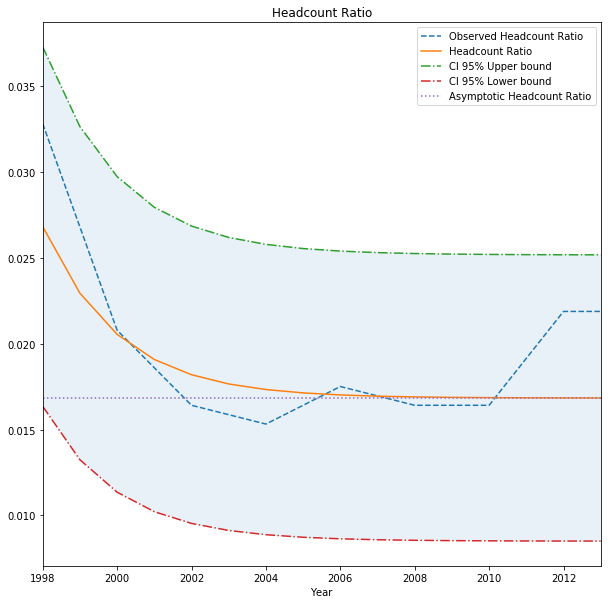

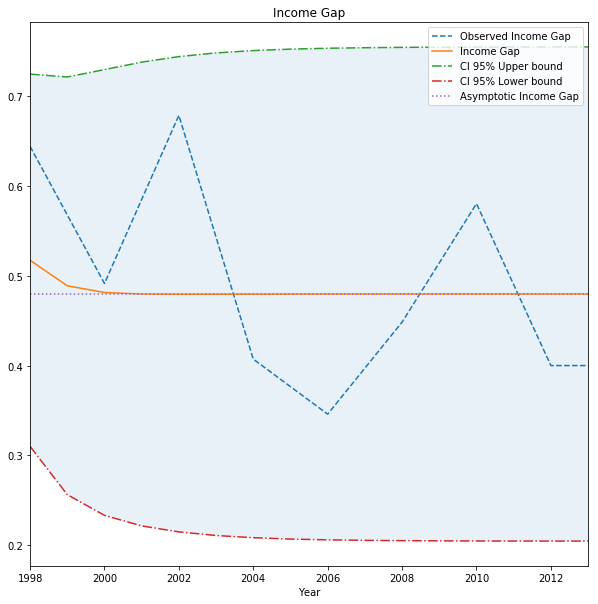

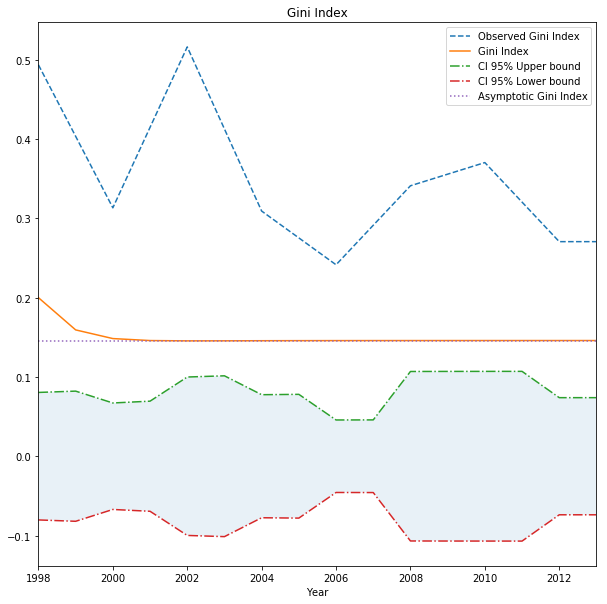

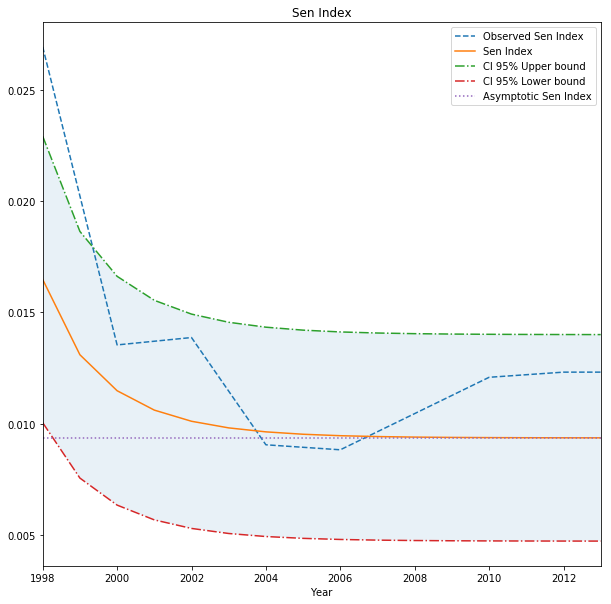

In [59]:
for i, title in {'H':'Headcount Ratio','I':'Income Gap','G':'Gini Index','S':'Sen Index'}.items():
    ax = poverty[[i+'_obs',i,i+'_U',i+'_L',i+'_inf']].ffill().plot(figsize=(10,10), style={i+'_obs':'--',i:'-',i+'_L':'-.',i+'_U':'-.',i+'_inf':':'},
                                                              title=title)
    ax.legend(('Observed '+title, title, 'CI 95% Upper bound', 'CI 95% Lower bound', 'Asymptotic '+title))
    ax.fill_between(poverty.index, poverty[i+'_U'], poverty[i+'_L'], alpha=0.1)
    ax.set_xlabel('Year')